In [3]:
using Plots, DifferentialEquations,LaTeXStrings

In [4]:
#def the problem
"""
du = change in state 
u = current state (ρ₂₂,ρ₁₁,ρ₂₁, ρ₁₂)
p = parameters (γ,Ω,γ⟂,Δ)
t = time

"""
function bloch!(du, u, p, t) 
    du[1] = -p[1]*u[1]-(im/2 *p[2]*u[3]-im/2*conj(p[2])*u[4]  )
    du[2] = +p[1]*u[1]+(im/2 *p[2]*u[3]-im/2*conj(p[2])*u[4]  )
    du[3] = -(im*p[4]+p[3])*u[3]-im/2*p[2]*(u[1]-u[2])
    du[4] = -(-im*p[4]+p[3])*u[4]+im/2*p[2]*(u[1]-u[2])
end


bloch!

Rate equations as given on the sheet:

In [17]:
#rate equations
function rateeq(t,P_10,P_20,A,B)
    P_1 = P_10-1/(A+2*B)*(1-exp(-(A+2*B)*t))*(B*P_10-(A+2*B)*P_20)
    P_2 = P_20+1/(A+2*B)*(1-exp(-(A+2*B)*t))*(B*P_10-(A+2*B)*P_20)
    return P_2,P_1
end

rateeq (generic function with 1 method)

Function to get the Einsteincoefficents for a given set of Bloch eq. parameters. See exericice a) for a derivation:

In [67]:
"""
p = parameters (γ,Ω,γ⟂,Δ)
"""
function getEinstein(p)
    A= (p[4]^2+p[3]^2)
    B = p[3]/(2*p[1])*p[2]^2
    return A,B
end

getEinstein

## Safety check
We start with the safty check, to make sure the implementation is correct.
 Solve problem problem for an simple decay :

In [77]:
# initial values
u0 = ComplexF64[1.0; 0;0.0;0.0] #u = current state (ρ₂₂,ρ₁₁,ρ₂₁, ρ₁₂)
# time to solve
tspan = (0.0, 100.0)
p = [0.1,0,0,0] #p = parameters (γ,Ω,γ⟂,Δ)
prob = ODEProblem(bloch!, u0, tspan, p)
sol = solve(prob) 

retcode: Success
Interpolation: specialized 7th order lazy interpolation, specialized 4rd order "free" stiffness-aware interpolation
t: 14-element Vector{Float64}:
   0.0
   0.00999000500498377
   0.10989005505482147
   1.1088905555531983
   4.563004540305134
  10.375580786394565
  17.827804493080816
  26.510618774963312
  36.624786724011635
  48.34869982262343
  66.43086174117931
  77.10008575485216
  95.4722397365088
 100.0
u: 14-element Vector{Vector{ComplexF64}}:
 [1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.9990014983343757 + 0.0im, 0.0009985016656243035 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.98907115305296 + 0.0im, 0.010928846947039998 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.8950380429195136 + 0.0im, 0.10496195708048639 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.6336234338315547 + 0.0im, 0.3663765661684453 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.3543188466121904 + 0.0im, 0.6456811533878096 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.16816991217225724 + 0.0im, 0.8318300878277428 

In [78]:
#function for plotting
f(t, x ) = (t, real(x))

f (generic function with 1 method)

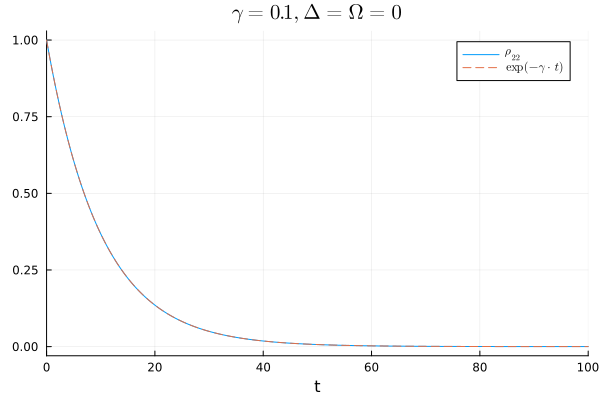

In [81]:
plot(sol,idxs =(f,0,1),label=L"\rho_{22}")
plot!(0:0.1:100,t->1*exp(-p[1]*t),ls=:dash,label=L"\exp{(-\gamma\cdot t)}", title=L"\gamma =0.1, \Delta=\Omega=0 ")
# savefig("test.pdf")

As expected with out any external field, a exponential decay is observable.

## Solving the Bloch eq for diffrent $\gamma_\perp$ and comparison to the Einsteinequations

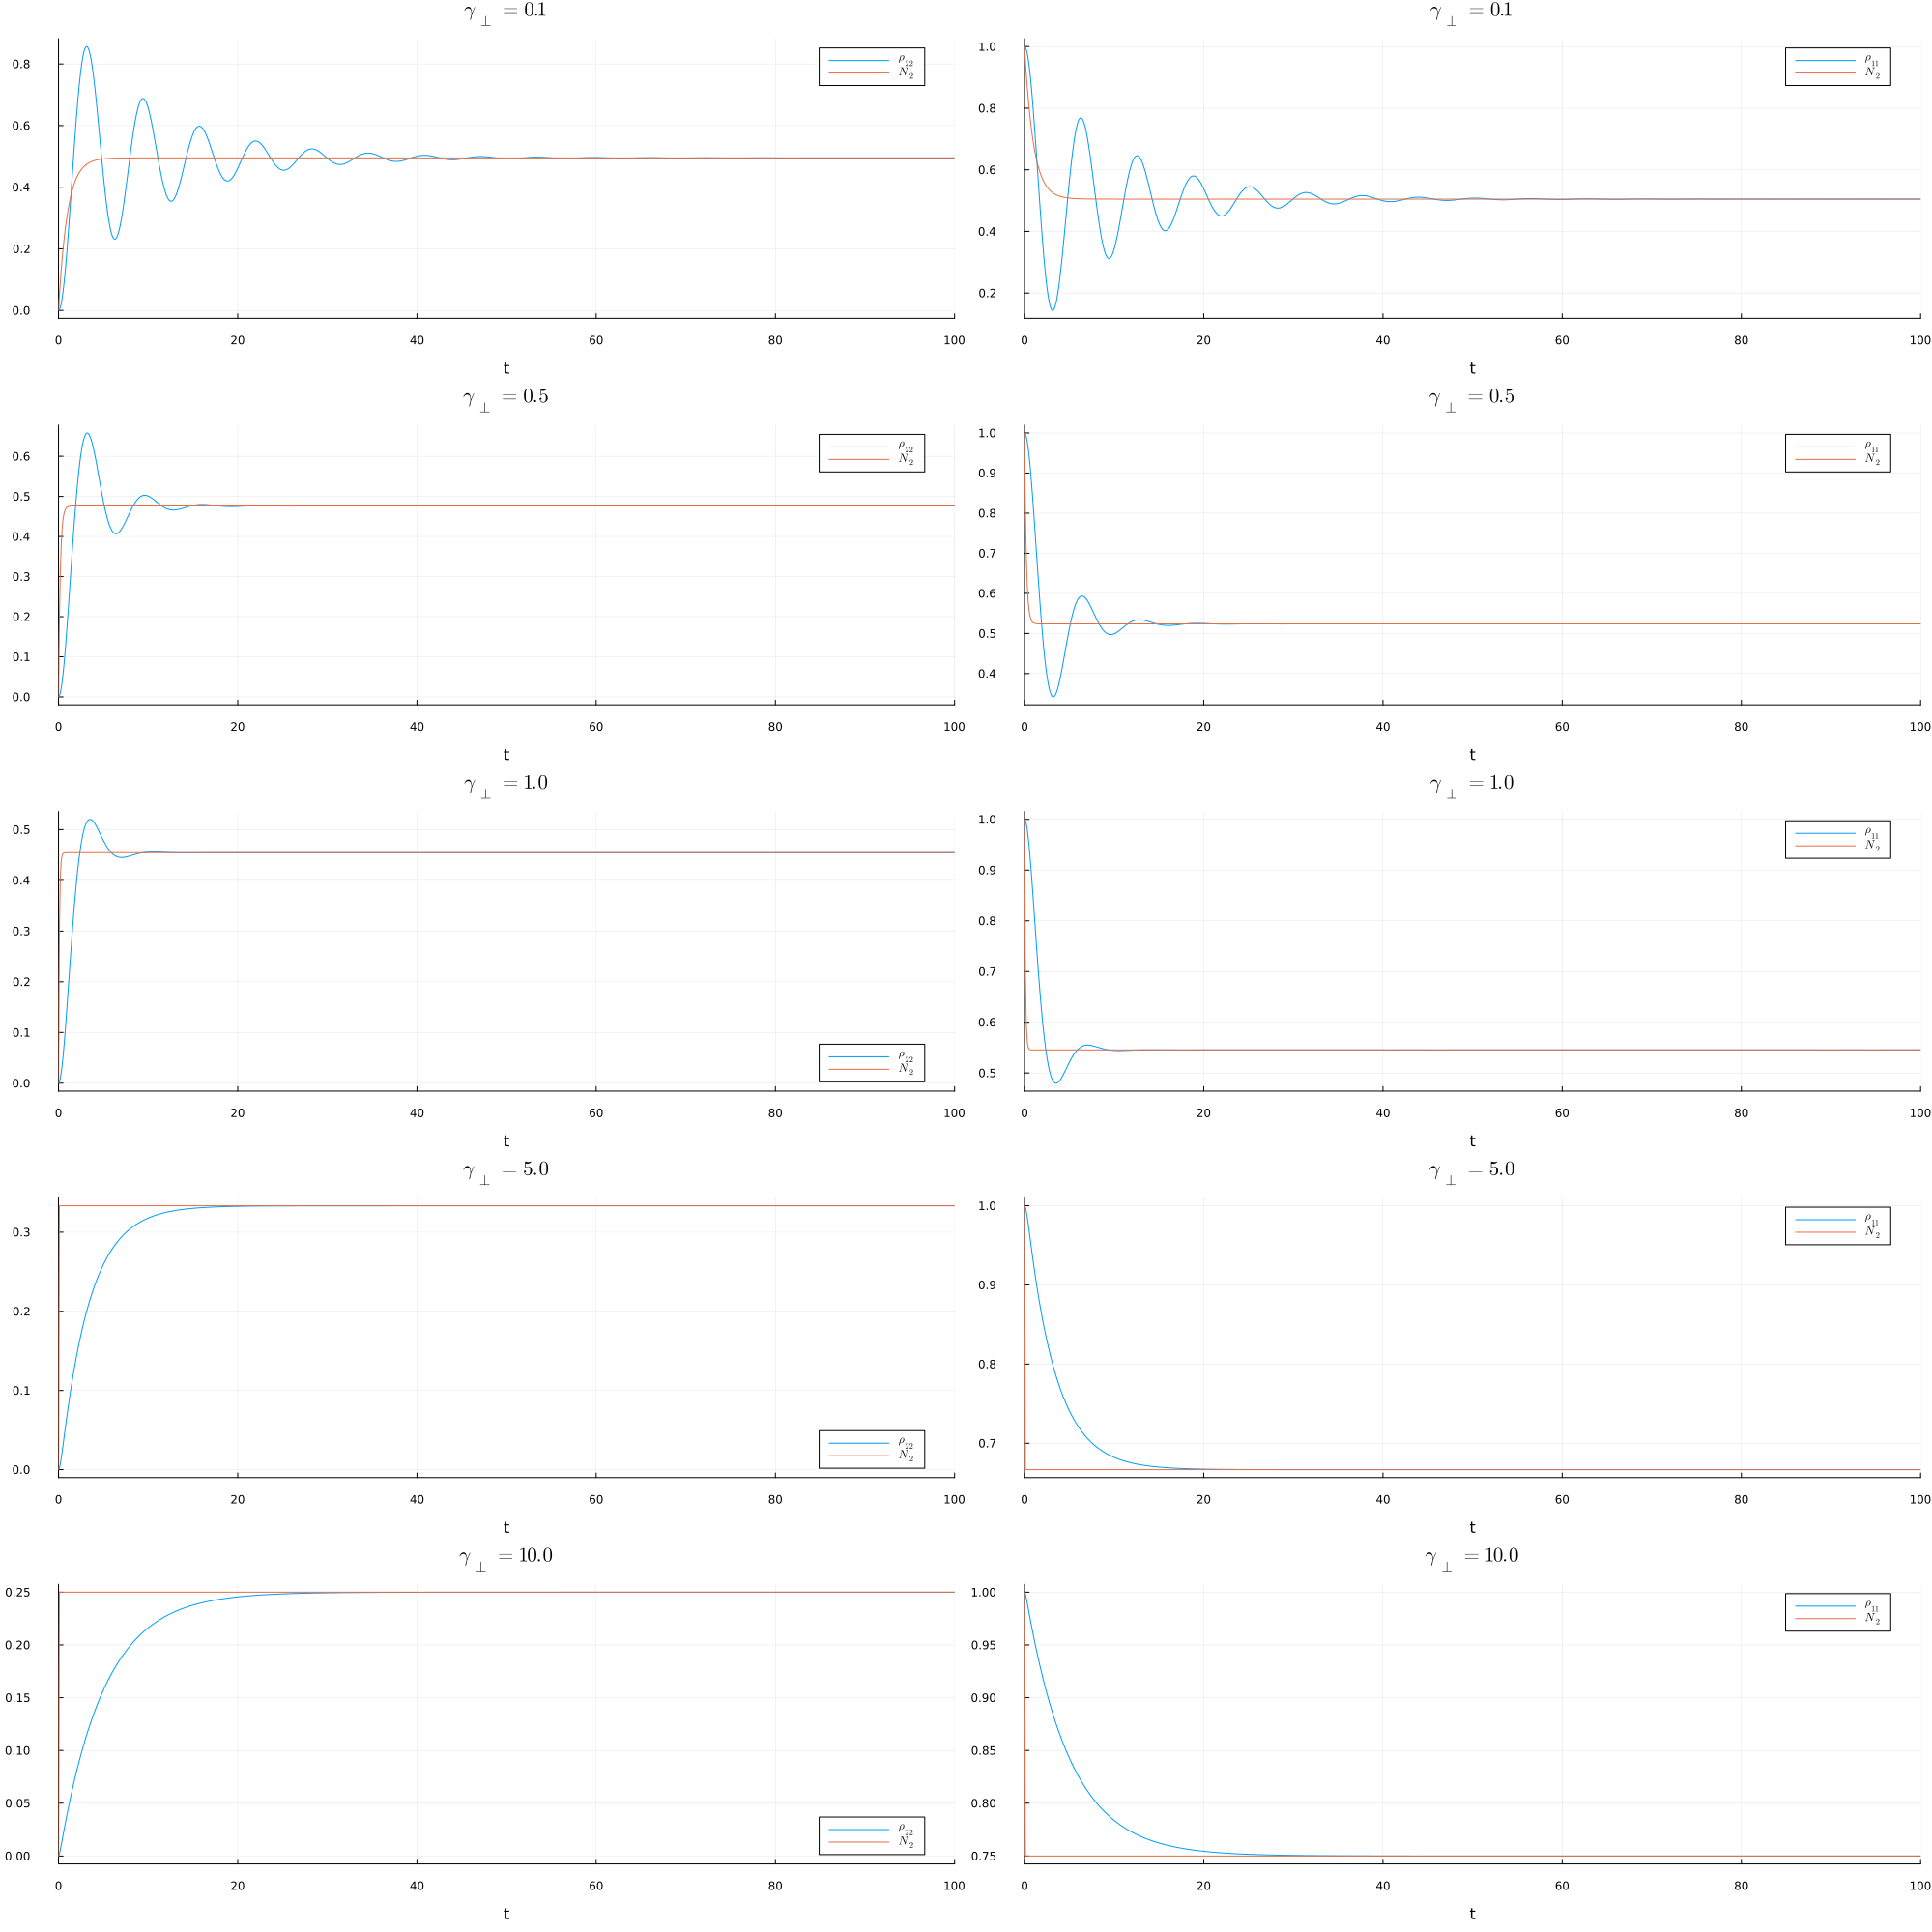

In [76]:
# initial values 
u0 = ComplexF64[0; 1;0.0;0.0] #u = current state (ρ₂₂,ρ₁₁,ρ₂₁, ρ₁₂)
# time to solve
tspan = (0.0, 100.0)
plots = []
γ_senkrs = [0.1,0.5,1,5,10]
for γ_senkr in γ_senkrs
    prob = ODEProblem(bloch!, u0, tspan, [0.1,1,γ_senkr,0]) #p = parameters (γ,Ω,γ⟂,Δ)
    sol = solve(prob) 
    Ps = (rateeq.(0:0.1:100,1,0,getEinstein([0.1,1,γ_senkr,0])...))
    P1 = [x[1] for x in Ps]
    P2 = [x[2] for x in Ps]
    a = plot(sol,idxs =(f,0,1),label=L"\rho_{22}",title = L"\gamma_\perp = %$γ_senkr")
    plot!(0:0.1:100, P1,label=L"N_2")
    b = plot(sol,idxs =(f,0,2),label=L"\rho_{11}", title=L"\gamma_\perp = %$γ_senkr")
        plot!(0:0.1:100, P2,label=L"N_2")
    append!(plots,(a,b))
end
plot(plot.(plots)..., layout=(length(γ_senkrs),2),size=(2000,2000))
# savefig("rest.pdf")